In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# For reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
def generate_synthetic_consumers(num_consumers=1000):
    """
    Returns a DataFrame of synthetic consumer profiles.
    Each row represents one consumer with attributes:
    - income
    - price_sensitivity
    - brand_loyalty
    """
    data = {
        'income': np.random.normal(loc=50000, scale=15000, size=num_consumers).clip(15000, 150000),
        'price_sensitivity': np.random.uniform(0.5, 2.0, size=num_consumers),  # 0.5 = not very sensitive, 2.0 = very sensitive
        'brand_loyalty': np.random.uniform(0, 1, size=num_consumers)  # 0 = no loyalty, 1 = very loyal
    }

    df = pd.DataFrame(data)
    return df

consumers_df = generate_synthetic_consumers(num_consumers=1000)
print(consumers_df.head())

         income  price_sensitivity  brand_loyalty
0  57450.712295           0.751224       0.219069
1  47926.035482           0.656852       0.036721
2  59715.328072           1.454645       0.108026
3  72845.447846           1.559714       0.338861
4  46487.699379           0.547379       0.802586


In [3]:
def competitor_pricing_strategy(day):
    """
    A simple competitor strategy:
    - Every 7 days, they run a discount, otherwise they maintain a base price.
    """
    base_price = 100
    discount_price = 80
    # If it's a multiple of 7, competitor runs a discount
    if day % 7 == 0:
        return discount_price
    else:
        return base_price

In [4]:
def simulate_consumer_purchase(consumer, our_price, competitor_price):
    """
    Return 0 if no purchase,
           1 if consumer buys our product,
           2 if consumer buys competitor's.
    """
    # Basic affordability check
    # The higher the price compared to income, the less likely they'll buy
    # The more price-sensitive, the less likely they'll buy at higher prices.
    affordability_our = consumer['income'] / (our_price * consumer['price_sensitivity'])
    affordability_comp = consumer['income'] / (competitor_price * consumer['price_sensitivity'])

    # If both are "affordable," brand loyalty helps tip the scale
    # Let's define a simple "attractiveness" score for each product
    our_attractiveness = affordability_our * (1 + consumer['brand_loyalty'])
    comp_attractiveness = affordability_comp * (1 + (1 - consumer['brand_loyalty']))

    # If both are below a small threshold, they might choose not to buy at all
    threshold = 0.5
    if our_attractiveness < threshold and comp_attractiveness < threshold:
        return 0  # No purchase

    # If both are above threshold, pick whichever is greater
    if our_attractiveness > comp_attractiveness:
        return 1  # Buys from us
    else:
        return 2  # Buys competitor's

In [5]:
def run_simulation(consumers_df, days=30):
    """
    Runs a simulation for the given number of days.
    Returns daily metrics: our_price, competitor_price, our_sales, comp_sales, our_revenue, comp_revenue.
    """
    # Starting our price
    our_price = 100

    # Lists to store results
    daily_data = {
        'day': [],
        'our_price': [],
        'competitor_price': [],
        'our_sales': [],
        'comp_sales': [],
        'our_revenue': [],
        'comp_revenue': []
    }

    for day in range(days):
        # (A) Determine competitor price
        comp_price = competitor_pricing_strategy(day)

        # (B) Our (business) naive strategy: occasionally discount
        # Example: every 7th day, reduce price by 5 for that day
        if day % 7 == 0 and day != 0:
            our_price = max(50, our_price - 5)  # ensure we don't go below 50, for example

        # (C) Simulate consumer purchases
        our_sales_count = 0
        comp_sales_count = 0

        for _, consumer in consumers_df.iterrows():
            purchase_decision = simulate_consumer_purchase(consumer, our_price, comp_price)
            if purchase_decision == 1:
                our_sales_count += 1
            elif purchase_decision == 2:
                comp_sales_count += 1

        our_revenue = our_sales_count * our_price
        comp_revenue = comp_sales_count * comp_price

        # (D) Store daily metrics
        daily_data['day'].append(day)
        daily_data['our_price'].append(our_price)
        daily_data['competitor_price'].append(comp_price)
        daily_data['our_sales'].append(our_sales_count)
        daily_data['comp_sales'].append(comp_sales_count)
        daily_data['our_revenue'].append(our_revenue)
        daily_data['comp_revenue'].append(comp_revenue)

    return pd.DataFrame(daily_data)

# Run the simulation for 30 days
results_df = run_simulation(consumers_df, days=30)
results_df.head(10)

,day,our_price,competitor_price,our_sales,comp_sales,our_revenue,comp_revenue
0,0,100,80,332,668,33200,53440
1,1,100,100,492,508,49200,50800
2,2,100,100,492,508,49200,50800
3,3,100,100,492,508,49200,50800
4,4,100,100,492,508,49200,50800
5,5,100,100,492,508,49200,50800
6,6,100,100,492,508,49200,50800
7,7,95,80,369,631,35055,50480
8,8,95,100,523,477,49685,47700
9,9,95,100,523,477,49685,47700


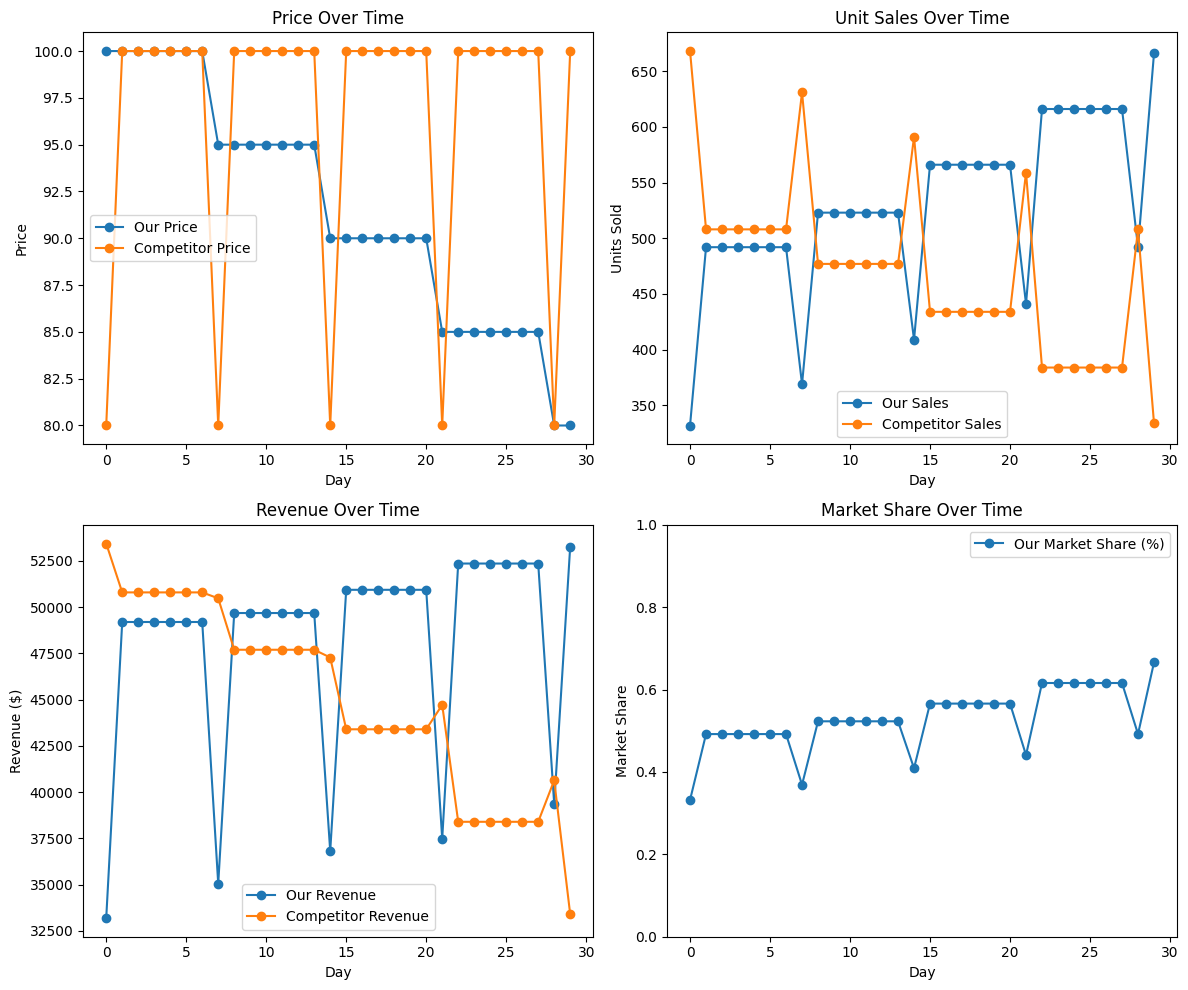

In [6]:
def plot_simulation_results(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # --- 1. Price Evolution ---
    axes[0, 0].plot(results_df['day'], results_df['our_price'], label='Our Price', marker='o')
    axes[0, 0].plot(results_df['day'], results_df['competitor_price'], label='Competitor Price', marker='o')
    axes[0, 0].set_title('Price Over Time')
    axes[0, 0].set_xlabel('Day')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()

    # --- 2. Sales ---
    axes[0, 1].plot(results_df['day'], results_df['our_sales'], label='Our Sales', marker='o')
    axes[0, 1].plot(results_df['day'], results_df['comp_sales'], label='Competitor Sales', marker='o')
    axes[0, 1].set_title('Unit Sales Over Time')
    axes[0, 1].set_xlabel('Day')
    axes[0, 1].set_ylabel('Units Sold')
    axes[0, 1].legend()

    # --- 3. Revenue ---
    axes[1, 0].plot(results_df['day'], results_df['our_revenue'], label='Our Revenue', marker='o')
    axes[1, 0].plot(results_df['day'], results_df['comp_revenue'], label='Competitor Revenue', marker='o')
    axes[1, 0].set_title('Revenue Over Time')
    axes[1, 0].set_xlabel('Day')
    axes[1, 0].set_ylabel('Revenue ($)')
    axes[1, 0].legend()

    # --- 4. Market Share ---
    # Calculate total daily purchases
    total_purchases = results_df['our_sales'] + results_df['comp_sales']
    # Avoid division by zero
    market_share = np.where(total_purchases > 0,
                            results_df['our_sales'] / total_purchases,
                            0)

    axes[1, 1].plot(results_df['day'], market_share, label='Our Market Share (%)', marker='o')
    axes[1, 1].set_ylim(0, 1)  # between 0 and 1
    axes[1, 1].set_title('Market Share Over Time')
    axes[1, 1].set_xlabel('Day')
    axes[1, 1].set_ylabel('Market Share')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

plot_simulation_results(results_df)